## You're ready to put into practice everything that you've learned so far. Here are the next steps for your capstone:







In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats.mstats import winsorize

## 1) Go out and find a dataset of interest. It could be from one of the recommended resources or some other aggregation. Or it could be something that you scraped yourself. Just make sure that it has lots of variables, including an outcome of interest to you.

* Pro football reference game info

        https://www.pro-football-reference.com/years/{1966-2017}/games.htm/games.htm#games::none


* Odds - money line, open/close lines historic info

        http://www.aussportsbetting.com/historical_data/nfl.xlsx
    

* Kaggle - NFL scores and betting data

        https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data
        
### Kaggle files:
       
* spreadspoke_scores.csv
* nfl_stadiums.csv
* nfl_teams.csv

In [2]:
all_dfs = []

# read seasons 1966 to 2017
for year in range(1966,2018):
    print(year)
    url = "https://www.pro-football-reference.com/years/" + str(year) + "/games.htm#games::none"
    df = pd.read_html(url)
    df = df[0]
    df['Year'] = year

    all_dfs.append(df)
    
scores1_df = pd.concat(all_dfs)
scores1_df.shape

1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


(12743, 15)

In [3]:
scores1_df.shape

(12743, 15)

In [4]:
odds_df = pd.read_excel("http://www.aussportsbetting.com/historical_data/nfl.xlsx")
scores2_df = pd.read_csv('data/spreadspoke_scores.csv', encoding = "ISO-8859-1", engine='python')
stadiums_df = pd.read_csv('data/nfl_stadiums.csv', encoding = "ISO-8859-1", engine='python')
teams_df = pd.read_csv('data/nfl_teams.csv', encoding = "ISO-8859-1", engine='python')

## 2) Explore the data. Get to know the data. Spend a lot of time going over its quirks. You should understand how it was gathered, what's in it, and what the variables look like.

In [5]:
scores1_df.head()

,Week,Day,Date,Time,Winner/tie,Unnamed: 5,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL,Year
0,1,Sat,September 10,NaN,Green Bay Packers,NaN,Baltimore Colts,boxscore,24,3,292,1,213,3,1966
1,1,Sun,September 11,NaN,Los Angeles Rams,@,Atlanta Falcons,boxscore,19,14,421,2,237,2,1966
2,1,Sun,September 11,NaN,Detroit Lions,NaN,Chicago Bears,boxscore,14,3,208,3,256,3,1966
3,1,Sun,September 11,NaN,San Francisco 49ers,NaN,Minnesota Vikings,boxscore,20,20,307,1,298,1,1966
4,1,Sun,September 11,NaN,Pittsburgh Steelers,NaN,New York Giants,boxscore,34,34,404,3,279,5,1966


In [6]:
scores1_df.shape

(12743, 15)

In [7]:
scores1_df.isna().mean()

Week          0.004081
Day           0.004081
Date          0.000000
Time          0.039787
Winner/tie    0.004081
Unnamed: 5    0.603155
Loser/tie     0.004081
Unnamed: 7    0.065134
PtsW          0.004081
PtsL          0.004081
YdsW          0.004081
TOW           0.004081
YdsL          0.004081
TOL           0.004081
Year          0.000000
dtype: float64

In [8]:
scores1_df = scores1_df.drop(columns=['Unnamed: 5', 'Unnamed: 7', 'Time'])

In [9]:
scores1_df = scores1_df.dropna()

In [10]:
scores1_df['Date'].value_counts()

Date           778
November 23    124
December 24    119
November 22    114
December 14    114
              ... 
February 7       2
February 4       2
February 6       2
January 29       1
February 2       1
Name: Date, Length: 162, dtype: int64

In [11]:
mos = {'January': 1
       ,'February': 2
       ,'March': 3
       ,'April': 4
       ,'May': 5
       ,'June': 6
       ,'July': 7
       ,'August': 8
       ,'September': 9
       ,'October': 10
       ,'November': 11
       ,'December': 12}

In [12]:
match = 'January'
for m in mos:
    if m != 'January':
        match = match + '|' + m
scores1_df = scores1_df[scores1_df['Date'].str.contains(match)]

In [13]:
scores1_df['Month'] = scores1_df['Date'].str.split(' ').str[0]
scores1_df['DayofMonth'] = scores1_df['Date'].str.split(' ').str[1].astype(int)

scores1_df['month_num'] = scores1_df['Month'].map(mos)

In [14]:
scores1_df

,Week,Day,Date,Winner/tie,Loser/tie,PtsW,PtsL,YdsW,TOW,YdsL,TOL,Year,Month,DayofMonth,month_num
0,1,Sat,September 10,Green Bay Packers,Baltimore Colts,24,3,292,1,213,3,1966,September,10,9
1,1,Sun,September 11,Los Angeles Rams,Atlanta Falcons,19,14,421,2,237,2,1966,September,11,9
2,1,Sun,September 11,Detroit Lions,Chicago Bears,14,3,208,3,256,3,1966,September,11,9
3,1,Sun,September 11,San Francisco 49ers,Minnesota Vikings,20,20,307,1,298,1,1966,September,11,9
4,1,Sun,September 11,Pittsburgh Steelers,New York Giants,34,34,404,3,279,5,1966,September,11,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,Division,Sun,January 14,Jacksonville Jaguars,Pittsburgh Steelers,45,42,378,0,545,2,2017,January,14,1
280,Division,Sun,January 14,Minnesota Vikings,New Orleans Saints,29,24,403,1,358,2,2017,January,14,1
281,ConfChamp,Sun,January 21,New England Patriots,Jacksonville Jaguars,24,20,344,1,374,0,2017,January,21,1
282,ConfChamp,Sun,January 21,Philadelphia Eagles,Minnesota Vikings,38,7,456,0,333,3,2017,January,21,1


## --------------------------------

In [15]:
odds_df.head()

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Odds Open,Home Odds Min,...,Total Score Close,Total Score Over Open,Total Score Over Min,Total Score Over Max,Total Score Over Close,Total Score Under Open,Total Score Under Min,Total Score Under Max,Total Score Under Close,Notes
0,2020-09-14,Denver Broncos,Tennessee Titans,14,16,NaN,NaN,NaN,1.76,1.76,...,41.0,1.9,1.86,1.9,1.9,1.9,1.9,1.9,1.9,NaN
1,2020-09-14,New York Giants,Pittsburgh Steelers,16,26,NaN,NaN,NaN,2.60,2.60,...,45.0,1.9,1.90,1.9,1.9,1.9,1.9,1.9,1.9,NaN
2,2020-09-13,Los Angeles Rams,Dallas Cowboys,20,17,NaN,NaN,NaN,2.15,2.15,...,51.5,1.9,1.90,1.9,1.9,1.9,1.9,1.9,1.9,NaN
3,2020-09-13,New Orleans Saints,Tampa Bay Buccaneers,34,23,NaN,NaN,NaN,1.47,1.47,...,47.5,1.9,1.90,1.9,1.9,1.9,1.9,1.9,1.9,NaN
4,2020-09-13,San Francisco 49ers,Arizona Cardinals,20,24,NaN,NaN,NaN,1.28,1.28,...,48.0,1.9,1.90,1.9,1.9,1.9,1.9,1.9,1.9,NaN


In [16]:
odds_df.shape

(3754, 45)

In [17]:
odds_df.describe()

,Home Score,Away Score,Home Odds Open,Home Odds Min,Home Odds Max,Home Odds Close,Away Odds Open,Away Odds Min,Away Odds Max,Away Odds Close,...,Total Score Max,Total Score Close,Total Score Over Open,Total Score Over Min,Total Score Over Max,Total Score Over Close,Total Score Under Open,Total Score Under Min,Total Score Under Max,Total Score Under Close
count,3754.000000,3754.000000,3754.000000,1618.00000,1618.000000,1618.000000,3754.000000,1618.000000,1618.000000,1618.000000,...,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000,1618.000000
mean,23.479489,21.238679,1.950855,1.83207,2.064315,1.954741,2.892580,2.573298,2.982897,2.780451,...,46.400494,45.441595,1.937429,1.903295,1.967795,1.933845,1.932285,1.924482,1.942302,1.936200
std,10.380618,10.035696,0.999993,0.79537,1.035032,0.912600,1.795221,1.342111,1.692837,1.560962,...,4.115823,4.115203,0.034949,0.033771,0.057890,0.041980,0.034153,0.033072,0.041815,0.043195
min,0.000000,0.000000,1.011111,1.02000,1.050000,1.020000,1.055556,1.030000,1.060000,1.050000,...,37.000000,35.000000,1.806000,1.740000,1.860000,1.740000,1.775000,1.830000,1.787000,1.813000
25%,16.000000,14.000000,1.340000,1.33300,1.416000,1.377000,1.695250,1.641000,1.813000,1.699000,...,43.500000,42.500000,1.900000,1.884000,1.900000,1.900000,1.900000,1.900000,1.900000,1.900000
50%,23.000000,21.000000,1.606061,1.57050,1.714000,1.640000,2.450000,2.250000,2.555000,2.400000,...,46.000000,45.000000,1.952000,1.900000,1.961000,1.925000,1.952000,1.909000,1.952000,1.925000
75%,30.000000,27.000000,2.250000,2.09000,2.397500,2.260000,3.480000,3.100000,3.560000,3.310000,...,49.000000,48.000000,1.952000,1.917000,2.010000,1.961000,1.952000,1.952000,1.970000,1.961000
max,62.000000,59.000000,12.000000,10.00000,15.500000,11.000000,31.000000,12.250000,16.000000,16.000000,...,63.500000,62.500000,2.170000,2.020000,2.170000,2.110000,2.120000,2.120000,2.090000,2.220000


In [18]:
odds_df.isna().mean()

Date                       0.000000
Home Team                  0.000000
Away Team                  0.000000
Home Score                 0.000000
Away Score                 0.000000
Overtime?                  0.941929
Playoff Game?              0.958977
Neutral Venue?             0.988013
Home Odds Open             0.000000
Home Odds Min              0.568993
Home Odds Max              0.568993
Home Odds Close            0.568993
Away Odds Open             0.000000
Away Odds Min              0.568993
Away Odds Max              0.568993
Away Odds Close            0.568993
Home Line Open             0.000000
Home Line Min              0.568993
Home Line Max              0.568993
Home Line Close            0.568993
Away Line Open             0.568993
Away Line Min              0.568993
Away Line Max              0.568993
Away Line Close            0.568993
Home Line Odds Open        0.568993
Home Line Odds Min         0.568993
Home Line Odds Max         0.568993
Home Line Odds Close       0

In [19]:
odds_df['Overtime?'].value_counts()

Y    218
Name: Overtime?, dtype: int64

In [20]:
odds_df['Playoff Game?'].value_counts()

Y    154
Name: Playoff Game?, dtype: int64

In [21]:
odds_df['Neutral Venue?'].value_counts()

Y    45
Name: Neutral Venue?, dtype: int64

In [22]:
odds_df['Overtime?'] = odds_df['Overtime?'].fillna('N')
odds_df['Playoff Game?'] = odds_df['Playoff Game?'].fillna('N')
odds_df['Neutral Venue?'] = odds_df['Neutral Venue?'].fillna('N')

In [23]:
odds_cols = ['Date'                       
            ,'Home Team'                 
            ,'Away Team'                 
            ,'Home Score'                
            ,'Away Score'               
            ,'Overtime?'               
            ,'Playoff Game?'            
            ,'Neutral Venue?'           
            ,'Home Odds Open'             
            ,'Away Odds Open'           
            ,'Total Score Open']         
odds_df = odds_df[odds_cols]

In [24]:
odds_df['date'] = pd.to_datetime(odds_df['Date'])
odds_df['year'] = odds_df['date'].dt.year
odds_df['month'] = odds_df['date'].dt.month
odds_df['DayofMonth'] = odds_df['date'].dt.day

In [25]:
odds_df

,Date,Home Team,Away Team,Home Score,Away Score,Overtime?,Playoff Game?,Neutral Venue?,Home Odds Open,Away Odds Open,Total Score Open,date,year,month,DayofMonth
0,2020-09-14,Denver Broncos,Tennessee Titans,14,16,N,N,N,1.760000,2.100000,42.0,2020-09-14,2020,9,14
1,2020-09-14,New York Giants,Pittsburgh Steelers,16,26,N,N,N,2.600000,1.550000,48.0,2020-09-14,2020,9,14
2,2020-09-13,Los Angeles Rams,Dallas Cowboys,20,17,N,N,N,2.150000,1.740000,50.0,2020-09-13,2020,9,13
3,2020-09-13,New Orleans Saints,Tampa Bay Buccaneers,34,23,N,N,N,1.470000,2.750000,49.5,2020-09-13,2020,9,13
4,2020-09-13,San Francisco 49ers,Arizona Cardinals,20,24,N,N,N,1.280000,3.750000,46.0,2020-09-13,2020,9,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3749,2006-09-10,Detroit Lions,Seattle Seahawks,6,9,N,N,N,3.500000,1.333333,44.0,2006-09-10,2006,9,10
3750,2006-09-10,Cleveland Browns,New Orleans Saints,14,19,N,N,N,1.500000,2.750000,36.5,2006-09-10,2006,9,10
3751,2006-09-10,Carolina Panthers,Atlanta Falcons,6,20,N,N,N,1.434783,2.900000,38.5,2006-09-10,2006,9,10
3752,2006-09-10,Arizona Cardinals,San Francisco 49ers,34,27,N,N,N,1.181818,5.000000,43.5,2006-09-10,2006,9,10


## --------------------------------

In [26]:
scores2_df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14,23,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45,7,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27,7,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82,NaN
3,9/9/1966,1966,2,False,Miami Dolphins,14,19,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78,NaN
4,9/10/1966,1966,1,False,Green Bay Packers,24,3,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62,NaN


In [27]:
scores2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12678 entries, 0 to 12677
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        12678 non-null  object 
 1   schedule_season      12678 non-null  int64  
 2   schedule_week        12678 non-null  object 
 3   schedule_playoff     12678 non-null  bool   
 4   team_home            12678 non-null  object 
 5   score_home           12678 non-null  int64  
 6   score_away           12678 non-null  int64  
 7   team_away            12678 non-null  object 
 8   team_favorite_id     10199 non-null  object 
 9   spread_favorite      10199 non-null  float64
 10  over_under_line      10189 non-null  object 
 11  stadium              12678 non-null  object 
 12  stadium_neutral      12678 non-null  bool   
 13  weather_temperature  11936 non-null  float64
 14  weather_wind_mph     11936 non-null  float64
 15  weather_humidity     8388 non-null  

In [28]:
scores2_df.isna().mean()

schedule_date          0.000000
schedule_season        0.000000
schedule_week          0.000000
schedule_playoff       0.000000
team_home              0.000000
score_home             0.000000
score_away             0.000000
team_away              0.000000
team_favorite_id       0.195536
spread_favorite        0.195536
over_under_line        0.196324
stadium                0.000000
stadium_neutral        0.000000
weather_temperature    0.058527
weather_wind_mph       0.058527
weather_humidity       0.338381
weather_detail         0.791844
dtype: float64

In [29]:
scores2_df = scores2_df.drop(columns = ['weather_humidity', 'weather_detail'])

In [30]:
scores2_df = scores2_df.dropna()

In [31]:
scores2_df['DayofMonth'] = pd.to_datetime(scores2_df['schedule_date']).dt.day
scores2_df['Month'] = pd.to_datetime(scores2_df['schedule_date']).dt.month
scores2_df['year'] = pd.to_datetime(scores2_df['schedule_date']).dt.year

### Add winning team column based on scores

In [32]:
scores2_df['Winner'] = scores2_df['team_home']

scores2_df.loc[scores2_df['score_away'] > scores2_df['score_home'], "Winner"] = scores2_df['team_away']

In [33]:
scores2_df

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,DayofMonth,Month,year,Winner
350,1/14/1968,1967,Superbowl,True,Green Bay Packers,33,14,Oakland Raiders,GB,-13.5,43,Orange Bowl,True,60.0,12.0,14,1,1968,Green Bay Packers
538,1/12/1969,1968,Superbowl,True,Baltimore Colts,7,16,New York Jets,IND,-18.0,40,Orange Bowl,True,66.0,12.0,12,1,1969,New York Jets
727,1/11/1970,1969,Superbowl,True,Kansas City Chiefs,23,7,Minnesota Vikings,MIN,-12.0,39,Tulane Stadium,True,55.0,14.0,11,1,1970,Kansas City Chiefs
916,1/17/1971,1970,Superbowl,True,Baltimore Colts,16,13,Dallas Cowboys,IND,-2.5,36,Orange Bowl,True,59.0,11.0,17,1,1971,Baltimore Colts
1105,1/16/1972,1971,Superbowl,True,Dallas Cowboys,24,3,Miami Dolphins,DAL,-6.0,34,Tulane Stadium,True,34.0,18.0,16,1,1972,Dallas Cowboys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12655,12/29/2019,2019,17,False,Dallas Cowboys,47,16,Washington Redskins,DAL,-12.5,47.5,AT&T Stadium,False,72.0,0.0,29,12,2019,Dallas Cowboys
12657,12/29/2019,2019,17,False,Detroit Lions,20,23,Green Bay Packers,GB,-13.0,44,Ford Field,False,72.0,0.0,29,12,2019,Green Bay Packers
12658,12/29/2019,2019,17,False,Houston Texans,14,35,Tennessee Titans,TEN,-10.0,43,NRG Stadium,False,72.0,0.0,29,12,2019,Tennessee Titans
12667,1/4/2020,2019,Wildcard,True,Houston Texans,22,19,Buffalo Bills,HOU,-2.5,43,NRG Stadium,False,72.0,0.0,4,1,2020,Houston Texans


## --------------------------------

In [34]:
stadiums_df.head()

,stadium_name,stadium_location,stadium_open,stadium_close,stadium_type,stadium_address,stadium_weather_station_code,stadium_weather_type,stadium_capacity,stadium_surface,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION
0,Alamo Dome,"San Antonio, TX",NaN,NaN,indoor,"100 Montana St, San Antonio, TX 78203",78203,dome,72000,FieldTurf,NaN,NaN,NaN,NaN,NaN
1,Alltel Stadium,"Jacksonville, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alumni Stadium,"Chestnut Hill, MA",NaN,NaN,outdoor,"Perimeter Rd, Chestnut Hill, MA 02467",2467,cold,NaN,Grass,NaN,NaN,NaN,NaN,NaN
3,Anaheim Stadium,"Anaheim, CA",1980.0,1994.0,outdoor,"2000 E Gene Autry Way, Anaheim, CA 92806",92806,warm,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arrowhead Stadium,"Kansas City, MO",1972.0,NaN,outdoor,"1 Arrowhead Dr, Kansas City, MO 64129",64129,cold,"76,416",Grass,US1MOJC0028,"KANSAS CITY 5.1 SE, MO US",39.0692,-94.4871,264.9


In [35]:
stadiums_df.isna().mean()

stadium_name                    0.00
stadium_location                0.00
stadium_open                    0.24
stadium_close                   0.59
stadium_type                    0.07
stadium_address                 0.09
stadium_weather_station_code    0.10
stadium_weather_type            0.07
stadium_capacity                0.61
stadium_surface                 0.47
STATION                         0.48
NAME                            0.48
LATITUDE                        0.48
LONGITUDE                       0.48
ELEVATION                       0.48
dtype: float64

In [36]:
cols = ['stadium_name', 'stadium_location', 'stadium_type', 'stadium_weather_type']
stadiums_df = stadiums_df[cols]

In [37]:
stadiums_df.isna().mean()

stadium_name            0.00
stadium_location        0.00
stadium_type            0.07
stadium_weather_type    0.07
dtype: float64

In [38]:
stadiums_df['stadium_type'] = stadiums_df['stadium_type'].fillna('unknown')
stadiums_df['stadium_weather_type'] = stadiums_df['stadium_weather_type'].fillna('unknown')

In [39]:
stadiums_df.isna().mean()

stadium_name            0.0
stadium_location        0.0
stadium_type            0.0
stadium_weather_type    0.0
dtype: float64

In [40]:
stadiums_df

,stadium_name,stadium_location,stadium_type,stadium_weather_type
0,Alamo Dome,"San Antonio, TX",indoor,dome
1,Alltel Stadium,"Jacksonville, FL",unknown,unknown
2,Alumni Stadium,"Chestnut Hill, MA",outdoor,cold
3,Anaheim Stadium,"Anaheim, CA",outdoor,warm
4,Arrowhead Stadium,"Kansas City, MO",outdoor,cold
...,...,...,...,...
95,War Memorial Stadium,"Buffalo, NY",outdoor,cold
96,Wembley Stadium,"London, UK",outdoor,moderate
97,Wrigley Field,"Chicago, IL",outdoor,cold
98,Yale Bowl,"New Haven, CT",outdoor,cold


## --------------------------------

In [41]:
teams_df.head(45)

,team_name,team_name_short,team_id,team_id_pfr,team_conference,team_division,team_conference_pre2002,team_division_pre2002
0,Arizona Cardinals,Cardinals,ARI,CRD,NFC,NFC West,NFC,NFC West
1,Phoenix Cardinals,Cardinals,ARI,CRD,NFC,NaN,NFC,NFC East
2,St. Louis Cardinals,Cardinals,ARI,ARI,NFC,NaN,NFC,NFC East
3,Atlanta Falcons,Falcons,ATL,ATL,NFC,NFC South,NFC,NFC West
4,Baltimore Ravens,Ravens,BAL,RAV,AFC,AFC North,AFC,AFC Central
5,Buffalo Bills,Bills,BUF,BUF,AFC,AFC East,AFC,AFC East
6,Carolina Panthers,Panthers,CAR,CAR,NFC,NFC South,NFC,NFC West
7,Chicago Bears,Bears,CHI,CHI,NFC,NFC North,NFC,NFC Central
8,Cincinnati Bengals,Bengals,CIN,CIN,AFC,AFC North,AFC,AFC Central
9,Cleveland Browns,Browns,CLE,CLE,AFC,AFC North,AFC,AFC Central


In [42]:
teams_df.shape

(41, 8)

In [43]:
teams_df.isna().mean()

team_name                  0.000000
team_name_short            0.000000
team_id                    0.000000
team_id_pfr                0.000000
team_conference            0.000000
team_division              0.195122
team_conference_pre2002    0.000000
team_division_pre2002      0.048780
dtype: float64

In [44]:
teams_df['team_division'] = teams_df['team_division'].fillna(teams_df['team_division_pre2002'])
teams_df['team_division'] = teams_df['team_division'].fillna('unknown')

In [45]:
teams_df = teams_df.drop(columns=['team_conference_pre2002', 'team_division_pre2002', 'team_id_pfr'])

In [46]:
teams_df

,team_name,team_name_short,team_id,team_conference,team_division
0,Arizona Cardinals,Cardinals,ARI,NFC,NFC West
1,Phoenix Cardinals,Cardinals,ARI,NFC,NFC East
2,St. Louis Cardinals,Cardinals,ARI,NFC,NFC East
3,Atlanta Falcons,Falcons,ATL,NFC,NFC South
4,Baltimore Ravens,Ravens,BAL,AFC,AFC North
5,Buffalo Bills,Bills,BUF,AFC,AFC East
6,Carolina Panthers,Panthers,CAR,NFC,NFC South
7,Chicago Bears,Bears,CHI,NFC,NFC North
8,Cincinnati Bengals,Bengals,CIN,AFC,AFC North
9,Cleveland Browns,Browns,CLE,AFC,AFC North


## Join dataframes together

In [47]:
scores1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11913 entries, 0 to 283
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Week        11913 non-null  object
 1   Day         11913 non-null  object
 2   Date        11913 non-null  object
 3   Winner/tie  11913 non-null  object
 4   Loser/tie   11913 non-null  object
 5   PtsW        11913 non-null  object
 6   PtsL        11913 non-null  object
 7   YdsW        11913 non-null  object
 8   TOW         11913 non-null  object
 9   YdsL        11913 non-null  object
 10  TOL         11913 non-null  object
 11  Year        11913 non-null  int64 
 12  Month       11913 non-null  object
 13  DayofMonth  11913 non-null  int32 
 14  month_num   11913 non-null  int64 
dtypes: int32(1), int64(2), object(12)
memory usage: 1.4+ MB


In [48]:
scores2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9677 entries, 350 to 12669
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   schedule_date        9677 non-null   object 
 1   schedule_season      9677 non-null   int64  
 2   schedule_week        9677 non-null   object 
 3   schedule_playoff     9677 non-null   bool   
 4   team_home            9677 non-null   object 
 5   score_home           9677 non-null   int64  
 6   score_away           9677 non-null   int64  
 7   team_away            9677 non-null   object 
 8   team_favorite_id     9677 non-null   object 
 9   spread_favorite      9677 non-null   float64
 10  over_under_line      9677 non-null   object 
 11  stadium              9677 non-null   object 
 12  stadium_neutral      9677 non-null   bool   
 13  weather_temperature  9677 non-null   float64
 14  weather_wind_mph     9677 non-null   float64
 15  DayofMonth           9677 non-null 

In [57]:
full_table = scores1_df.merge(scores2_df,
                              left_on=['month_num', 'DayofMonth', 'Year', 'Winner/tie'], 
                              right_on=['Month', 'DayofMonth', 'year', 'Winner'])

In [58]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9065 entries, 0 to 9064
Data columns (total 33 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Week                 9065 non-null   object 
 1   Day                  9065 non-null   object 
 2   Date                 9065 non-null   object 
 3   Winner/tie           9065 non-null   object 
 4   Loser/tie            9065 non-null   object 
 5   PtsW                 9065 non-null   object 
 6   PtsL                 9065 non-null   object 
 7   YdsW                 9065 non-null   object 
 8   TOW                  9065 non-null   object 
 9   YdsL                 9065 non-null   object 
 10  TOL                  9065 non-null   object 
 11  Year                 9065 non-null   int64  
 12  Month_x              9065 non-null   object 
 13  DayofMonth           9065 non-null   int32  
 14  month_num            9065 non-null   int64  
 15  schedule_date        9065 non-null   o

In [59]:
full_table[['Date', 'Winner/tie', 'Winner', 'PtsW', 'PtsL', 'score_home', 'score_away']]

,Date,Winner/tie,Winner,PtsW,PtsL,score_home,score_away
0,September 1,Tampa Bay Buccaneers,Tampa Bay Buccaneers,31,16,31,16
1,September 2,Philadelphia Eagles,Philadelphia Eagles,23,17,23,17
2,September 2,Miami Dolphins,Miami Dolphins,9,7,7,9
3,September 2,Minnesota Vikings,Minnesota Vikings,28,22,28,22
4,September 2,Houston Oilers,Houston Oilers,29,27,27,29
...,...,...,...,...,...,...,...
9060,December 31,Cincinnati Bengals,Cincinnati Bengals,31,27,27,31
9061,December 31,Atlanta Falcons,Atlanta Falcons,22,10,22,10
9062,December 31,San Francisco 49ers,San Francisco 49ers,34,13,13,34
9063,December 31,Arizona Cardinals,Arizona Cardinals,26,24,24,26


In [60]:
full_table = full_table.merge(odds_df,
                              left_on=['month_num', 'DayofMonth', 'year', 'team_home'], 
                              right_on=['month', 'DayofMonth', 'year', 'Home Team'])

In [61]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985 entries, 0 to 2984
Data columns (total 46 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Week                 2985 non-null   object        
 1   Day                  2985 non-null   object        
 2   Date_x               2985 non-null   object        
 3   Winner/tie           2985 non-null   object        
 4   Loser/tie            2985 non-null   object        
 5   PtsW                 2985 non-null   object        
 6   PtsL                 2985 non-null   object        
 7   YdsW                 2985 non-null   object        
 8   TOW                  2985 non-null   object        
 9   YdsL                 2985 non-null   object        
 10  TOL                  2985 non-null   object        
 11  Year                 2985 non-null   int64         
 12  Month_x              2985 non-null   object        
 13  DayofMonth           2985 non-nul

In [62]:
# Remove unneeded rows
full_table = full_table.drop(columns=['Date_x', 'Month_x'
                                        ,'schedule_date'
                                        ,'schedule_season'
                                        ,'schedule_playoff'
                                        ,'Week'
                                        ,'Month_y'
                                        ,'year'
                                        ,'Winner'
                                        ,'Home Score'
                                        ,'Away Score'
                                        ,'Home Team'
                                        ,'Away Team'
                                        ,'Date_y'
                                        ,'month_num'])


In [63]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985 entries, 0 to 2984
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Day                  2985 non-null   object        
 1   Winner/tie           2985 non-null   object        
 2   Loser/tie            2985 non-null   object        
 3   PtsW                 2985 non-null   object        
 4   PtsL                 2985 non-null   object        
 5   YdsW                 2985 non-null   object        
 6   TOW                  2985 non-null   object        
 7   YdsL                 2985 non-null   object        
 8   TOL                  2985 non-null   object        
 9   Year                 2985 non-null   int64         
 10  DayofMonth           2985 non-null   int32         
 11  schedule_week        2985 non-null   object        
 12  team_home            2985 non-null   object        
 13  score_home           2985 non-nul

In [66]:
# Rename columns
full_table.rename(columns = {'Day':'weekday'
                             ,'Winner/tie':'winner'
                             ,'Loser/tie':'loser'
                             ,'PtsW':'pts_win' 
                             ,'PtsL':'pts_lose'
                             ,'YdsW':'yds_win' 
                             ,'YdsL':'yds_lose'
                             ,'TOW':'TO_win' 
                             ,'TOL':'TO_lose'
                             ,'Year':'year'
                             ,'weather_temperature':'w_temp'
                             ,'weather_wind_mph':'w_wind_mph'
                             ,'Overtime?':'overtime'
                             ,'Playoff Game?':'playoff'
                             ,'Neutral Venue?':'neutral_venue'
                             ,'Home Odds Open':'home_odds_open'
                             ,'Away Odds Open':'away_odds_open'
                             ,'Total Score Open':'total_score_open'}
                             , inplace = True)

## 3) Model your outcome of interest. You should try several different approaches and really work to tune a variety of models before using the model evaluation techniques to choose what you consider to be the best performer. Make sure to think about explanatory versus predictive power, and experiment with both.

In [67]:
cols = full_table.columns
cols

Index(['weekday', 'winner', 'loser', 'pts_win', 'pts_lose', 'yds_win',
       'TO_win', 'yds_lose', 'TO_lose', 'year', 'DayofMonth', 'schedule_week',
       'team_home', 'score_home', 'score_away', 'team_away',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'stadium',
       'stadium_neutral', 'w_temp', 'w_wind_mph', 'overtime', 'playoff',
       'neutral_venue', 'home_odds_open', 'away_odds_open', 'total_score_open',
       'date', 'month'],
      dtype='object')

## Find and handle outliers

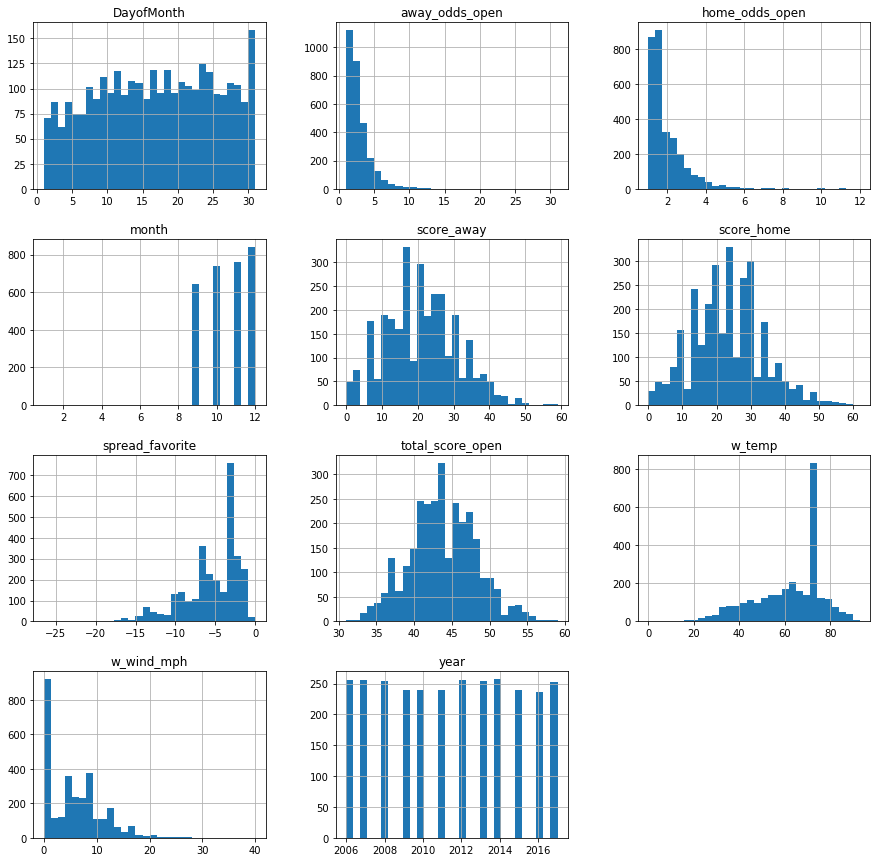

In [68]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numeric_df = full_table.select_dtypes(include=numerics)
numeric_df.hist(bins=30, figsize=(15, 15))
plt.show()

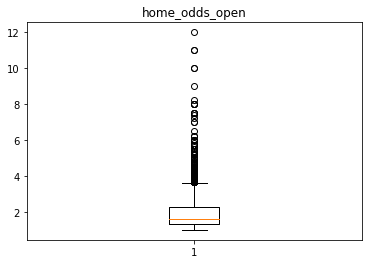

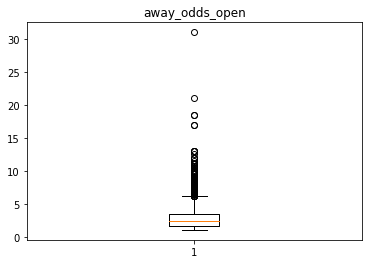

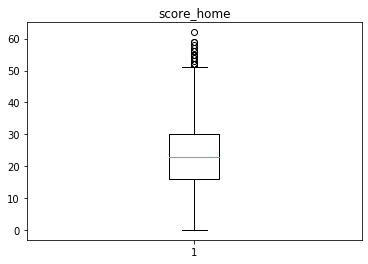

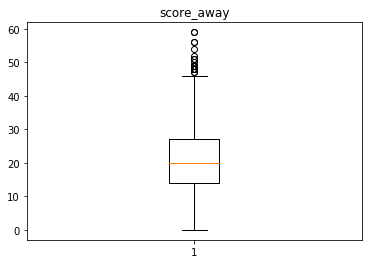

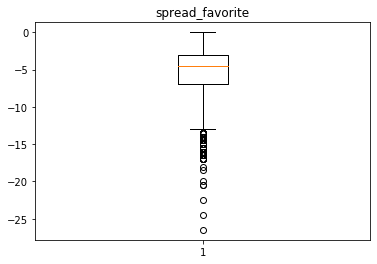

In [72]:
plt.boxplot(full_table['home_odds_open'])
plt.title('home_odds_open')
plt.show()
plt.boxplot(full_table['away_odds_open'])
plt.title('away_odds_open')
plt.show()
plt.boxplot(full_table['score_home'])
plt.title('score_home')
plt.show()
plt.boxplot(full_table['score_away'])
plt.title('score_away')
plt.show()
plt.boxplot(full_table['spread_favorite'])
plt.title('spread_favorite')
plt.show()

In [76]:
full_table['w_home_odds'] = winsorize(full_table["home_odds_open"], (0, 0.10))
full_table['w_away_odds'] = winsorize(full_table["away_odds_open"], (0, 0.10))
full_table['w_score_home'] = winsorize(full_table["score_home"], (0, 0.10))
full_table['w_score_away'] = winsorize(full_table["score_away"], (0, 0.10))
full_table['w_spread_fav'] = winsorize(full_table["spread_favorite"], (0, 0.10))

,weekday,winner,loser,pts_win,pts_lose,yds_win,TO_win,yds_lose,TO_lose,year,...,home_odds_open,away_odds_open,total_score_open,date,month,w_home_odds,w_away_odds,w_score_home,w_score_away,w_spread_fav
0,Thu,Pittsburgh Steelers,Miami Dolphins,28,17,342,1,278,2,2006,...,1.800000,2.050000,34.0,2006-09-07,9,1.800000,2.050000,28,17,-2.0
1,Sun,Cincinnati Bengals,Kansas City Chiefs,23,10,236,1,289,3,2006,...,1.769231,2.100000,48.5,2006-09-10,9,1.769231,2.100000,10,23,-2.0
2,Sun,Baltimore Ravens,Tampa Bay Buccaneers,27,0,271,0,142,3,2006,...,1.625000,2.450000,33.5,2006-09-10,9,1.625000,2.450000,0,27,-3.0
3,Sun,New England Patriots,Buffalo Bills,19,17,319,2,240,0,2006,...,1.173913,5.250000,41.0,2006-09-10,9,1.173913,5.000000,19,17,-10.0
4,Sun,Philadelphia Eagles,Houston Texans,24,10,441,1,241,0,2006,...,3.500000,1.333333,38.0,2006-09-10,9,3.100000,1.333333,10,24,-6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2980,Sun,Cincinnati Bengals,Baltimore Ravens,31,27,359,1,312,1,2017,...,1.227000,4.770000,40.5,2017-12-31,12,1.227000,4.770000,27,31,-8.0
2981,Sun,Atlanta Falcons,Carolina Panthers,22,10,371,0,248,3,2017,...,1.505000,2.780000,47.0,2017-12-31,12,1.505000,2.780000,22,10,-5.0
2982,Sun,San Francisco 49ers,Los Angeles Rams,34,13,461,3,251,2,2017,...,1.526000,2.710000,44.0,2017-12-31,12,1.526000,2.710000,13,34,-6.0
2983,Sun,Arizona Cardinals,Seattle Seahawks,26,24,259,1,296,0,2017,...,1.298000,3.930000,40.5,2017-12-31,12,1.298000,3.930000,24,26,-8.0


In [106]:
full_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985 entries, 0 to 2984
Data columns (total 38 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   weekday           2985 non-null   object        
 1   winner            2985 non-null   object        
 2   loser             2985 non-null   object        
 3   pts_win           2985 non-null   object        
 4   pts_lose          2985 non-null   object        
 5   yds_win           2985 non-null   object        
 6   TO_win            2985 non-null   object        
 7   yds_lose          2985 non-null   object        
 8   TO_lose           2985 non-null   object        
 9   year              2985 non-null   int64         
 10  DayofMonth        2985 non-null   int32         
 11  schedule_week     2985 non-null   object        
 12  team_home         2985 non-null   object        
 13  score_home        2985 non-null   int64         
 14  score_away        2985 n

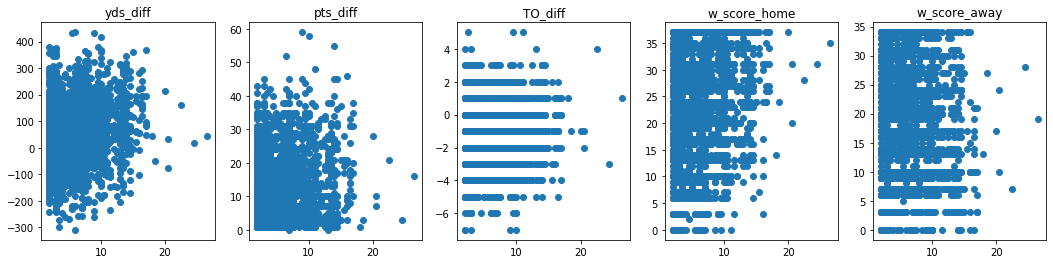

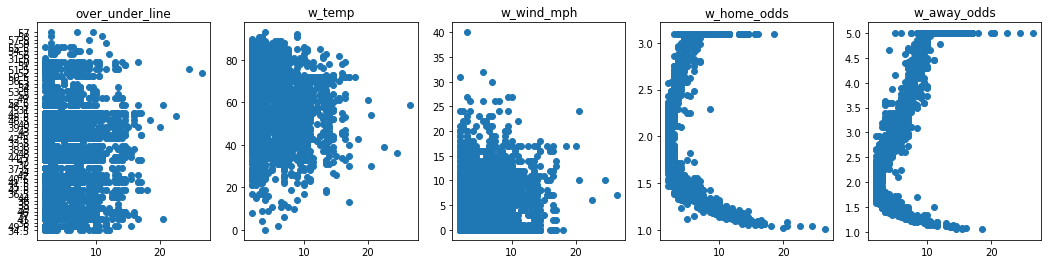

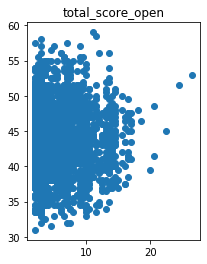

In [111]:
## Scatter plots against the spread
full_table['yds_diff'] = full_table['yds_win'].astype(int) - full_table['yds_lose'].astype(int)
full_table['pts_diff'] = full_table['pts_win'].astype(int) - full_table['pts_lose'].astype(int)
full_table['TO_diff'] = full_table['TO_win'].astype(int) - full_table['TO_lose'].astype(int)

cols = ['yds_diff'
        , 'pts_diff'
        , 'TO_diff'
        , 'w_score_home'
        , 'w_score_away'
        , 'over_under_line'
        , 'w_temp'
        , 'w_wind_mph'
        , 'w_home_odds'
        , 'w_away_odds'
        , 'total_score_open']

x = 1
plt.figure(figsize=(18,4))
for col in cols:
    plt.subplot(1,5,x)
    plt.scatter(abs(full_table["w_spread_fav"]), full_table[col])
    plt.title(col)
    
    if (x == 5):
        x = 1
        plt.show()
        plt.figure(figsize=(18,4))
    else:
        x += 1

In [93]:
corrmat = full_table.corr()

In [94]:
corrmat

,year,DayofMonth,score_home,score_away,spread_favorite,stadium_neutral,w_temp,w_wind_mph,home_odds_open,away_odds_open,total_score_open,month,w_home_odds,w_away_odds,w_score_home,w_score_away,w_spread_fav,yds_diff,pts_diff
year,1.000000,-0.010603,0.053293,0.036844,0.093429,0.025675,0.085743,-0.175905,-0.025100,-0.052776,0.338358,-0.012652,0.010771,-0.039825,0.052834,0.043982,0.092599,-0.020132,-0.033835
DayofMonth,-0.010603,1.000000,0.001767,-0.006595,-0.040133,0.037474,-0.047323,0.033542,0.011729,0.022692,-0.011239,-0.064910,-0.011721,0.011077,0.001288,-0.007253,-0.037121,-0.013376,0.025306
score_home,0.053293,0.001767,1.000000,-0.061773,-0.141988,-0.036615,-0.012959,-0.086756,-0.255574,0.252295,0.195532,-0.012414,-0.296506,0.291134,0.977134,-0.068522,-0.143330,0.062723,0.231040
score_away,0.036844,-0.006595,-0.061773,1.000000,0.163174,0.038438,0.054927,-0.082409,0.257414,-0.260213,0.182869,-0.009762,0.289469,-0.305847,-0.059361,0.979435,0.165294,-0.123011,-0.098296
spread_favorite,0.093429,-0.040133,-0.141988,0.163174,1.000000,0.001294,0.101752,-0.033426,-0.009922,-0.730032,-0.012414,-0.078741,0.248478,-0.654227,-0.134630,0.173254,0.997095,-0.162312,-0.150691
stadium_neutral,0.025675,0.037474,-0.036615,0.038438,0.001294,1.000000,0.001301,0.014742,0.116426,-0.056716,0.002527,-0.006300,0.088856,-0.073657,-0.038493,0.032026,0.003482,0.013433,0.037975
w_temp,0.085743,-0.047323,-0.012959,0.054927,0.101752,0.001301,1.000000,-0.309620,0.027707,-0.090103,0.120092,-0.483434,0.043524,-0.077823,-0.003842,0.063132,0.102427,-0.011522,-0.037706
w_wind_mph,-0.175905,0.033542,-0.086756,-0.082409,-0.033426,0.014742,-0.309620,1.000000,0.003659,0.036974,-0.236505,0.032273,-0.006331,0.015325,-0.091645,-0.088948,-0.035495,0.020483,0.028488
home_odds_open,-0.025100,0.011729,-0.255574,0.257414,-0.009922,0.116426,0.027707,0.003659,1.000000,-0.527592,0.030121,0.030266,0.861150,-0.683196,-0.258841,0.241153,-0.009415,-0.012615,-0.016291
away_odds_open,-0.052776,0.022692,0.252295,-0.260213,-0.730032,-0.056716,-0.090103,0.036974,-0.527592,1.000000,-0.006057,0.030335,-0.668797,0.849500,0.249763,-0.260419,-0.737889,0.127289,0.119936


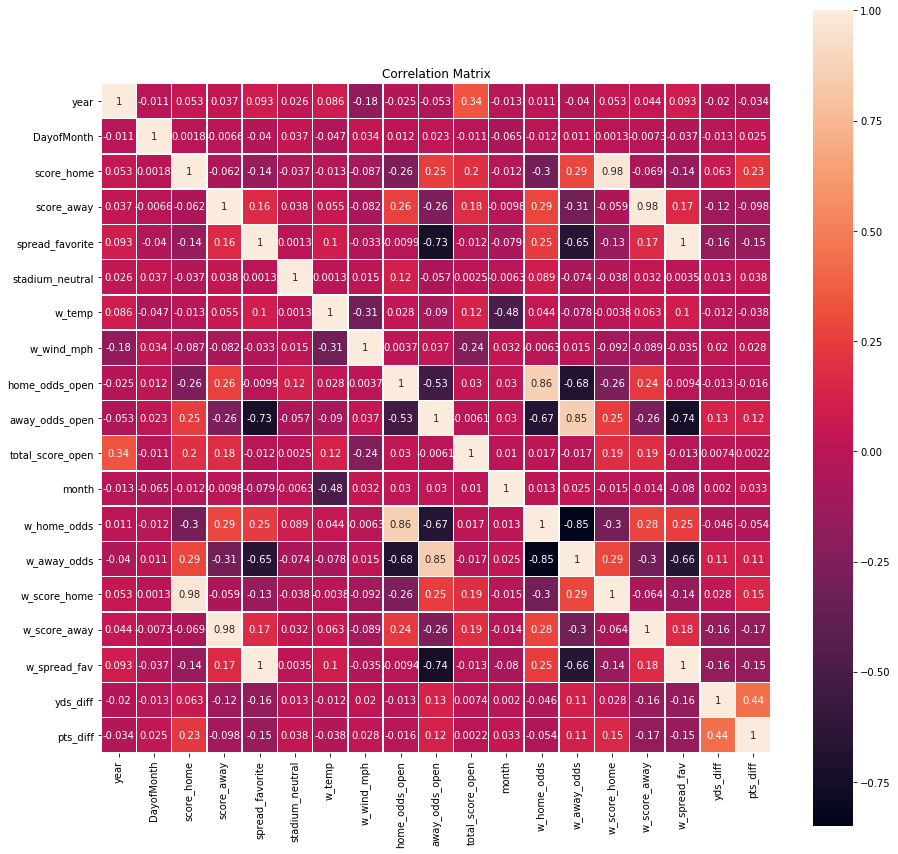

In [96]:
plt.figure(figsize=(15, 15))

sns.heatmap(corrmat, square=True, annot=True, linewidths=.5)
plt.title("Correlation Matrix")

plt.show()

In [97]:
# Choose columns based on correlation with spread_favorite or w_spread_fav
num_cols = ['w_score_home', 'w_score_away', 'w_temp', 
              'w_home_odds', 'w_away_odds', 'yds_diff', 'pts_diff']

## Next, to prepare for your presentation, create a slide deck and a 15-minute presentation that guides viewers through your model. Be sure to cover a few specific topics:

* ## A specified research question that your model addresses
* ## How you chose your model specification and what alternatives you compared it to
* ## The practical uses of your model for an audience of interest
* ## Any weak points or shortcomings of your model

## This presentation is not a drill. You'll be presenting this slide deck live to a group as the culmination of all your work so far on supervised learning. As a secondary matter, your slides and the Jupyter Notebook should be worthy of inclusion as examples of your work product when applying to jobs.